# MIMIQ demo - Quantum Volume
QPerfect 2025 https://qperfect.io/

The interactive version of this demo can be found at https://github.com/qperfect-io/MimiqDemos/blob/main/QV/qv.ipynb

## Introduction and context
Quantum Volume (QV) is a powerful full system benchmark that helps us gauge the performance and capabilities of quantum processors. In simple terms, it measures the size of the largest random circuit, with equal width and depth, that a quantum computer can successfully run. In this demo, we use MIMIQ to construct and run QV benchmark circuits for simulations up to 22 qubits. Now, you might wonder why it's interesting to benchmark an emulator in this way at all. Well, there are several good reasons:

1. It allows us to compare performance with actual quantum hardware.
2. We can test how well simulators scale, both in exact and approximate regimes.
3. We can better understand how a successful QV test depends on the number of qubits, types of errors, compilation strategies and hardware constraints

It's worth noting that QV benchmarks are exceptionally challenging, both for quantum computers and simulators. This is because the random circuits used in QV benchmarks generate high levels of entanglement and have little structure that can be exploited. By testing MIMIQ on QV circuits, we can explore quantum computing capabilities at the limits of what's currently possible, both for quantum hardware and emulators, on the most challenging quantum circuits.

### The Quantum Volume Benchmark

The QV benchmark involves creating a series of square circuits (equal width and depth) with random two-qubit gates. The process includes:

1. Running multiple randomly generated quantum circuits of fixed depth and width, consisting of random two-qubit gates (sampled from the special unitary group SU(4)), typically applied to random pairs of qubits in each layer.

2. Calculating the heavy output probability (HOP), which measures how often the device produces outputs with probabilities higher than the median probability of all possible outcomes, as predicted by classical simulations.

3. Verifying whether the HOP exceeds a threshold of 2/3 with a specified statistical confidence level, typically 97.5%.

4. The largest successful circuit depth d determines the Quantum Volume, calculated as QV = 2^d.

### MIMIQ Features used in this demo
- Fidelity estimation
- Large bond dimension
- Local statevector simulator (coming soon)

## MIMIQ implementation

Let's begin by importing the necessary packages and establishing a connection to the MIMIQ service.

In [329]:
from mimiqcircuits import *
from mimiqcircuits.visualization import *
from quantaniumpy import Quantanium # local statevector simulator
import numpy as np
from scipy.stats import unitary_group # for generating SU(4) random matrices
from collections import Counter # for analyzing samples
import matplotlib.pyplot as plt

# create a connection to the MIMIQ server
conn = MimiqConnection(QPERFECT_CLOUD2)
conn.connect()

Connection:
├── url: https://mimiqfast.qperfect.io/api
├── Computing time: 1643/10000 minutes
├── Executions: 236/10000
├── Max time limit per request: 180 minutes
├── Default time limit is equal to max time limit: 180 minutes
└── status: open

Next, we'll define the random unitary SU(4) gates

In [316]:
def random_su4():
	return GateCustom(unitary_group.rvs(4))

We'll also create the function for generating the quantum volume circuits

In [317]:
def qv_circuit(nqubits, depth):
    """ Generate a random Quantum Volume circuit """
    circuit = Circuit()
    for layer in range(depth):
        perm = np.random.permutation(nqubits).tolist()
        for i in range(0, nqubits, 2):
            if i < nqubits - 1:
                circuit.push(random_su4(), perm[i], perm[i+1])   
    return circuit

Now, we're all set to perform our simulation. Let's start with one exemplary circuit, execute it on MIMIQ, and analyze the sample results.

In [42]:
n, d = 12, 12
nsamples = 2**16
circuit = qv_circuit(n,d)
job = conn.execute(circuit, nsamples = nsamples)

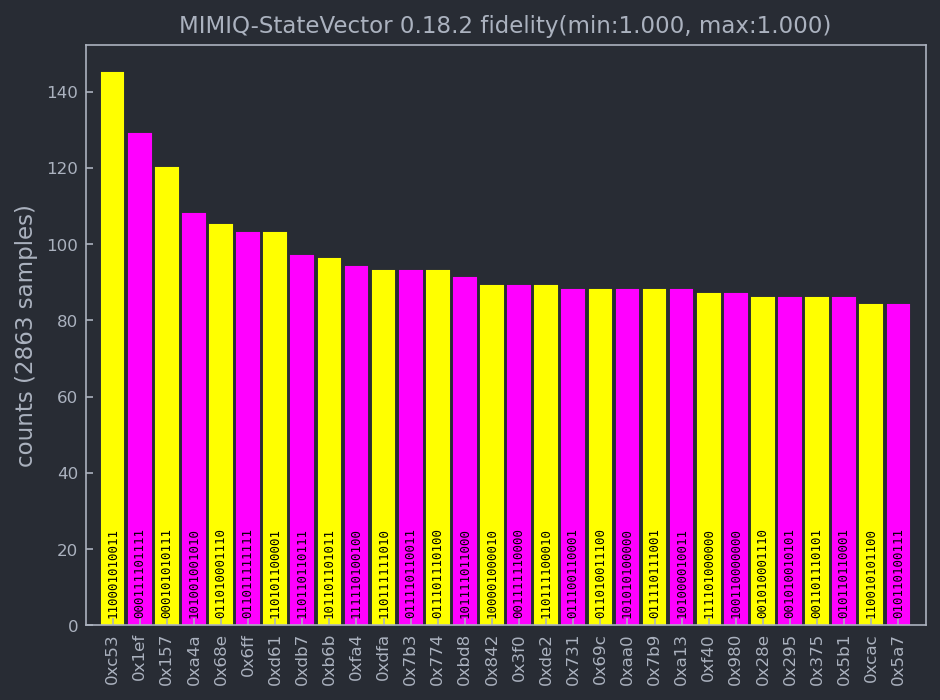

In [43]:
result = conn.get_result(job)
figure(figsize=(4,4))
plothistogram(result, num_outcomes=30);

As you might expect, the output bitstrings appear to be random. But how can we determine if this randomness is exactly what we're looking for?

The Quantum Volume test hinges on the probability of what we call "Heavy Outputs" - outputs that occur more frequently than the median output probability. To better understand this, let's estimate the median output probability and visualize the results with a histogram. You'll notice the histogram has a characteristic shape.

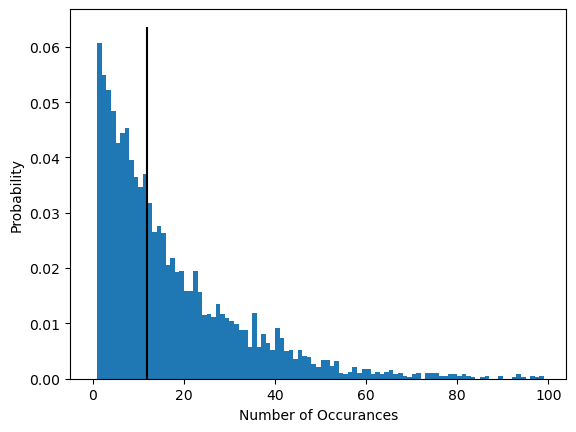

In [10]:
outcomes = result.histogram()

def calc_median_output_prob(samples):
    """
    Calculate the median output probability from samples
    """
    hist = Counter(samples)
    sorted_counts = sorted(hist.values())
    return sorted_counts[len(hist) // 2] / len(samples)

# create a plot of the outcome probabilities
plt.hist(outcomes.values(), bins=range(100), histtype='stepfilled', density=True)

# Get median output counts
moc = nsamples * calc_median_output_prob(result.cstates)
plt.vlines(moc, *plt.gca().get_ylim(), colors='k', linestyles='-')
plt.xlabel('Number of Occurances')
plt.ylabel('Probability')
plt.show()

Looking at our histogram, we can see a significant number of outcomes occurring more often than the median output counts (represented by the vertical line). This is a good sign, but let's dig deeper.

### Calculating the Heavy Output Probability
Now, let's define a function to calculate the Heavy Output Probability (HOP). In principle this calculation requires perfectly accurate information on probability of each possible output (we'll come to that later). However, we'll work with what we have for the moment and see how far we can get based on samples alone.

In [11]:
def calc_heavy_output_prob(samples):
    """ 
    Estimate the heavy output probability from samples
    
    The median output probability is calculated from the available samples
    """
    median = calc_median_output_prob(samples)
    
    hist = Counter(samples)
    total_samples = len(samples)
    heavy_sum = 0
    for counts in hist.values():
        if counts > median * total_samples:
            heavy_sum += counts
    return heavy_sum / total_samples

To pass the Quantum Volume test, we need a Heavy Output Probability greater than 2/3, with a confidence interval of at least 97%. 

In [12]:
mop = calc_median_output_prob(result.cstates)
hop = calc_heavy_output_prob(result.cstates)
success = hop > 2/3

print(f"QV Test Results:")
print(f"  Fidelity Estimate: {result.fidelities[0]}")
print(f"  Median Output Counts: {mop*nsamples}")
print(f"  Heavy Output Probability (est.): {hop:.4f}")
print(f"  Success (HOP > 2/3): {'Yes' if success else 'No'}")

QV Test Results:
  Fidelity Estimate: 0.9999999999999543
  Median Output Counts: 12.0
  Heavy Output Probability (est.): 0.8185
  Success (HOP > 2/3): Yes


Great news! Our simulation passes the Quantum Volume test and the HOP in this case is close to the ideal expected large-$n$ limit result of $1/2+\ln(2)/2\approx 0.85$ [https://arxiv.org/abs/1612.05903], within the expected sampling errors.

Lets try another test, this time with a slightly larger number of qubits. 

In [14]:
n, d = 16, 16
nsamples = 2**16
circuit = qv_circuit(n,d)
job = conn.execute(circuit, nsamples = nsamples)

result = conn.get_result(job)
mop = calc_median_output_prob(result.cstates)
hop = calc_heavy_output_prob(result.cstates)
success = hop > 2/3

print(f"QV Test Results:")
print(f"  Fidelity Estimate: {result.fidelities[0]}")
print(f"  Median Output Counts: {mop*nsamples}")
print(f"  Heavy Output Probability (est.): {hop:.4f}")
print(f"  Success (HOP > 2/3): {'Yes' if success else 'No'}")

QV Test Results:
  Fidelity Estimate: 1.0
  Median Output Counts: 2.0
  Heavy Output Probability (est.): 0.4981
  Success (HOP > 2/3): No


This time we see that the Heavy Output Probability has decreased (if not, try running it a few times for different circuit realizations), even though our simulation is effectively exact? So, what's going on?

The answer lies in the finite number of samples we're using ($2^{16}$ in this case). The drop in Heavy Output Probability is actually a consequence of overestimating the median output probability. This overestimation occurs because heavy outputs, by their nature, are disproportionately represented in our finite sample. It's a classic case of sampling bias.

To circumvent this problem, one needs to compare the sampled outputs with exact probabilities simulated on a classical computer. This is acceptable for smallish numbers of qubits $<32$ but quickly becomes impossible for larger problems. This is arguably one of the main weaknesses of quantum volume as a benchmark for scalable quantum computers.

## Going further with MIMIQ
Let's dive deeper into our quantum volume investigation, using MIMIQ's MPS simulator engine to explore how simulation errors affect the QV results. We'll employ batch mode to run multiple QV circuits of varying sizes in order to check how it scales with system size.

First, we'll set up some helper functions to streamline the analysis. These functions allow us to compute the heavy output probability from exact statevector calculations.

In [28]:
def get_heavy_outputs_exact(circ):
    processor = Quantanium()
    processor.execute(circ)
    probs = np.abs(processor.get_statevector())**2
    
    sorted_indices = np.argsort(probs)
    return sorted_indices[len(probs) // 2 + 1:]

def calc_heavy_output_prob_exact(samples, heavy_outputs):
    """ 
    Calculate the heavy output probability from samples
    using a list of heavy output indices `heavy_outputs`
    """
    heavy_sum = 0
    for bs in samples:
        if BitString(bs).tointeger(endianess = 'little') in heavy_outputs:
            heavy_sum += 1
    
    return heavy_sum / len(samples)

Let's set up our MPS simulations. The following function accepts a list of circuit sizes (n_list) and generates and submits circuits to the MIMIQ server, returning a list of jobs and the corresponding heavy output indices obtained from a local state vector simulation.

In [288]:
def qv_experiment(n_list, **kwargs):
    expt = {'job':[], 'circuits':[], 
            'heavyoutputs':[], 'nqubits':[],
            'fidelities':[], 'runtimes':[], 
            'hops':[], **kwargs}

    for n in n_list:
        # generate quantum volume circuit
        circuit = qv_circuit(n, n)

        # submit jobs to the server
        job = conn.execute(circuit, **kwargs)

        # get the heavy outputs using the local sv simulator
        expt['heavyoutputs'].append(get_heavy_outputs_exact(circuit))
        expt['job'].append(job)
        expt['nqubits'].append(n)
    return expt   

OK, now lets run the Quantum Volume 'experiment' up to 22 qubits. This will test the limits of the MPS emulator, so it may take some minutes to get all the results back from the server. As a starting point we'll use the default value of the bonddim parameter of 256, although below we will also see results with a high bonddim of 2048.

In [330]:
n_list = range(10,23)
kwargs = {'bonddim':256, 
          'algorithm':'mps', 
          'nsamples':2**16, 
          'timelimit':180}
expt256 = qv_experiment(n_list, **kwargs)

# large scale simulation - warning, takes >1 hour to run
#kwargs = {'bonddim':2048, 'algorithm':'mps', 'nsamples':2**16, 'timelimit':180}
#expt2048 = qv_experiment(n_list, **kwargs)

Once the jobs are submitted you can run the following cell to see the status of results.

In [312]:
def process_experiment(conn, expt):
    keys = ['nqubits', 'fidelities', 'hops', 'runtimes']
    print("Quantum Volume Experiment")
    print(*(f"{k}:{v}" for k, v in expt.items() if not isinstance(v, list)), sep=', ')
    print("=" * 80, ' '.join(f"{k:<20}" for k in keys), sep='\n')
    
    expt.update({k: [] for k in keys})
    for job, heavies in zip(expt['job'], expt['heavyoutputs']):
        if not conn.isJobDone(job): continue
        try:
            result = conn.get_result(job)
            out = {'nqubits': len(result.cstates[0]), 
                   'fidelities': result.fidelities[0],
                   'hops': calc_heavy_output_prob_exact(result.cstates, heavies),
                   'runtimes': result.timings['total']}
            [expt[k].append(v) for k, v in out.items()]
            print(' '.join(f"{expt[k][-1]:<20}" for k in keys))
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
    return expt

process_experiment(conn, expt256);
#process_experiment(conn, expt2048);

Quantum Volume Experiment
bonddim:256, algorithm:mps, nsamples:65536, timelimit:180
nqubits              fidelities           hops                 runtimes            
10                   0.9999999999999718   0.8437042236328125   0.693294125         
11                   0.9999999999999547   0.8424835205078125   1.2214340369999999  
12                   0.9999999999999372   0.8460845947265625   2.182573638         
13                   0.9999999999999412   0.8448944091796875   3.548694            
14                   0.9999999999999467   0.84912109375        7.304561294         
15                   0.999999999999913    0.84600830078125     14.371064569        
16                   0.9999999999999059   0.84130859375        30.213618565        
17                   0.035368528965853706 0.519073486328125    57.504100900000005  
18                   0.05500691568497023  0.5177001953125      159.534367883       
19                   0.0044169986730133995 0.498748779296875    207.00777365

Once our results are ready, we'll process and visualize them.

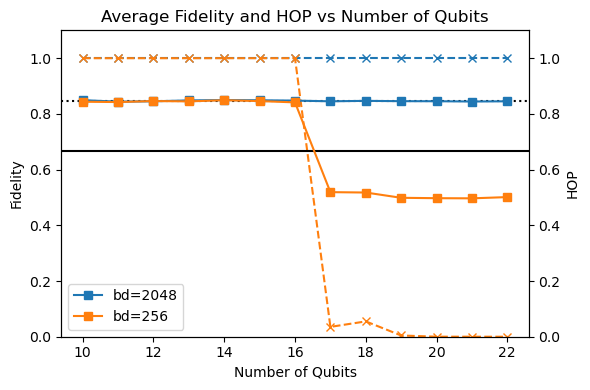

In [313]:
def plot_experiments(*experiments, labels=None):
    fig, ax1 = plt.subplots(figsize=(6, 4))
    ax2 = ax1.twinx()
    
    for i, expt in enumerate(experiments):
        label = labels[i] if labels else f'Experiment {i+1}'
        n = len(expt['fidelities'])
        ax1.plot(expt['nqubits'][:n], expt['fidelities'], 'x--', label=f'{label}')
        ax2.plot(expt['nqubits'][:n], expt['hops'], 's-', label=f'{label}')

    ax1.set_xlabel('Number of Qubits')
    ax1.set_ylabel('Fidelity')
    ax1.set_ylim(0, 1.1)
    ax1.axhline(y=1/2+np.log(2)/2, color='k', linestyle=':')
    ax1.axhline(y=2/3, color='k', linestyle='-')
    
    ax2.set_ylabel('HOP')
    ax2.set_ylim(0, 1.1)
    
    plt.title('Average Fidelity and HOP vs Number of Qubits')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()
    
plot_experiments(expt256, labels=["bd=256"])

Here we observe that the heavy output probability (square symbols) surpasses the success criteria of 2/3 and closely matches the ideal value of $\approx 0.85$ for circuit sizes below a threshold number of qubits. For a bond dimension of 256, a sudden drop occurs above 16 qubits, where the heavy output probability falls to approximately 0.5. This coincides with the fidelity estimate, depicted with the crosses, dropping from 1.0 (exact) to close to zero  Crucially, the QV success threshold is strongly dependent on the bond dimension, which governs the accuracy of the MPS method approximation which for this circuit drops very quickly with depth. Notably, increasing the bond dimension to 2048 extends this threshold beyond 22 qubits, indicating an achieved quantum volume of 2^22.

## Conclusions
In our exploration of random quantum circuit simulations, we've uncovered several key findings.
- **Matrix-Product-State simulations: More than an approximate method:** Often labeled as "approximate methods" or "1D methods," we have shown that MPS can operate in exact regimes and successfully simulate complex quantum circuits, including those with all-to-all connectivity with high fidelities.  The true limitation of MPS simulations lies not in their dimensionality or approximation nature, but in managing the growth of entanglement within the system. Random circuit benchmarks like Quantum Volume (QV) test the limits of such simulators and can provide a valuable metric for comparing simulators.
- **MIMIQ's competitive edge:** While other demonstrations focus on quantum algorithms with large qubit counts, this demo highlights MIMIQ's matrix product state emulator capability to achieve substantial quantum volumes up to $2^{22}$ within reasonable timeframes. To our knowledge, this represents the largest verified quantum volume reported for a tensor network-based simulator, surpassing even the best quantum computers to date.
- **MIMIQ as a reliable benchmarking tool:** A limitation of the original QV benchmarking formulation is its reliance on exact simulations for verification. This demo reveals a strong correlation between the QV success threshold and the point where estimated circuit fidelity drops. This suggests that matrix product simulations might provide alternative metrics for the QV pass criteria, especially in regimes where exact statevector simulations become infeasible.